<a href="https://colab.research.google.com/github/Zia-Ul-Hasan/Churn-Prediction-IBM-telco/blob/main/Churn_Prediction_model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib

In [104]:
df= pd.read_excel('/content/Eda_data.xlsx')


In [105]:
df= df.drop(['State','Zip Code','Churn Reason','City','Latitude','Longitude'], axis = 1)

Vriable Encoding

In [107]:
df.describe()

,Tenure Months,Monthly Charges,Total Charges,Churn Score
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,58.715301
std,24.545260,30.085974,2266.771362,21.531321
min,1.000000,18.250000,18.800000,5.000000
25%,9.000000,35.587500,401.450000,40.000000
50%,29.000000,70.350000,1397.475000,61.000000
75%,55.000000,89.862500,3794.737500,75.000000
max,72.000000,118.750000,8684.800000,100.000000


In [103]:
print(df.tail(4))
def encode_var (df_series):
  if df_series.dtype=='object':
    df_series= LabelEncoder().fit_transform(df_series)
    return df_series
  else:
    return df_series
df= df.apply (lambda x: encode_var(x))
print(df.head(4))

      Gender Senior Citizen Partner Dependents  Tenure Months Phone Service  \
7028    Male             No     Yes        Yes             24           Yes   
7029  Female             No     Yes        Yes             72           Yes   
7030  Female             No     Yes        Yes             11            No   
7031    Male             No      No         No             66           Yes   

        Multiple Lines Internet Service Online Security Online Backup  ...  \
7028               Yes              DSL             Yes            No  ...   
7029               Yes      Fiber optic              No           Yes  ...   
7030  No phone service              DSL             Yes            No  ...   
7031                No      Fiber optic             Yes            No  ...   

     Tech Support Streaming TV Streaming Movies        Contract  \
7028          Yes          Yes              Yes        One year   
7029           No          Yes              Yes        One year   
7030        

In [ ]:
CORRELATION MATRIX

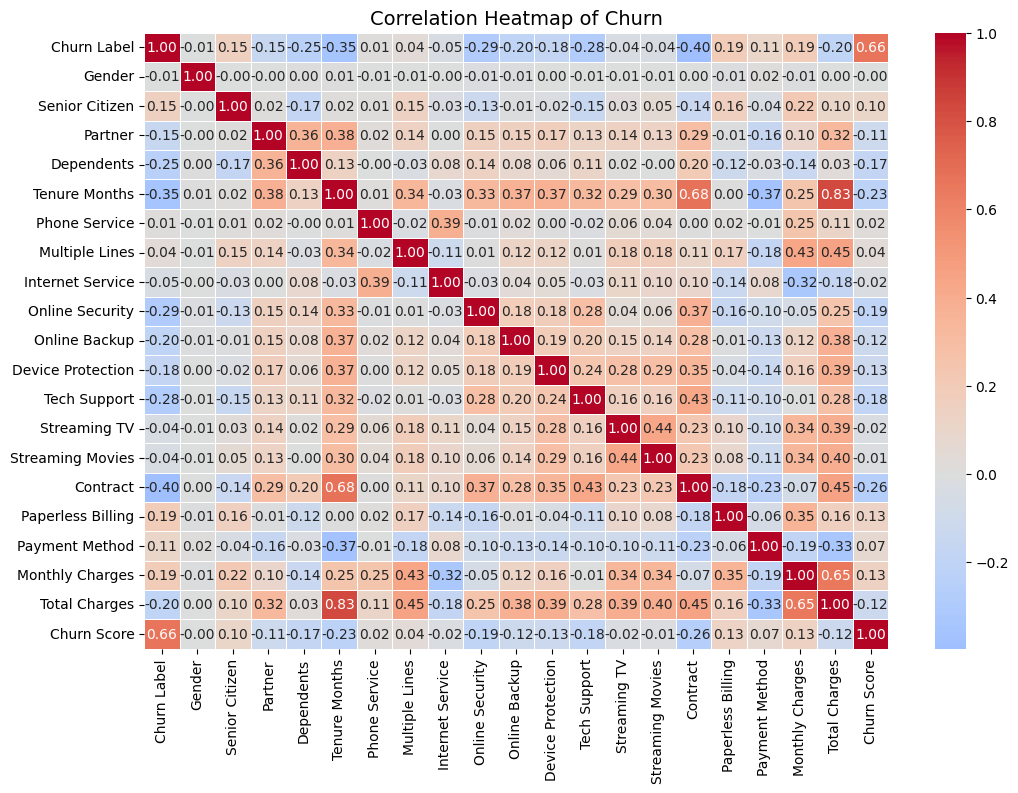

In [65]:
corr_matrix = df.corr()

cols = ['Churn Label'] + [col for col in corr_matrix.columns if col != 'Churn Label']
corr_matrix = corr_matrix[cols].loc[cols]

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)

plt.title("Correlation Heatmap of Churn", fontsize=14)
plt.show()

SPLITTING AND PREPARING FOR MODELING

In [66]:
X = df.drop('Churn Label', axis=1)
Y = df['Churn Label']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3, random_state=42, stratify=y)
print(Y_train.value_counts(normalize=True))
print(Y_test.value_counts(normalize=True))

Churn Label
0    0.734254
1    0.265746
Name: proportion, dtype: float64
Churn Label
0    0.734123
1    0.265877
Name: proportion, dtype: float64


In [106]:
churned = X_train[Y_train == 1]
not_churned = X_train[Y_train == 0]

y_churned = Y_train[Y_train == 1]
y_not_churned = Y_train[Y_train == 0]

churned_upsampled, y_churned_upsampled = resample(churned, y_churned,replace=True,n_samples=len(not_churned),random_state=42)
X_train = pd.concat([not_churned, churned_upsampled])
Y_train = pd.concat([y_not_churned, y_churned_upsampled])
new_train_dist = Y_train.value_counts(normalize=True) * 100
print(f"\n Train Dist\n{new_train_dist}")


 Train Dist
Churn Label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [68]:
def model(method , x_train , y_train , x_test , y_test):
  method.fit(x_train,y_train)
  predictions= method.predict(x_test)
  con_matrix =confusion_matrix(y_test, predictions)

  percentages = (con_matrix / np.sum(con_matrix, axis=1)[:, np.newaxis]).round(2) * 100
  labels = [[f"{con_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(con_matrix.shape[1])] for i in range(con_matrix.shape[0])]
  labels = np.asarray(labels)

  sns.heatmap(con_matrix,annot=labels, fmt='', cmap='Blues')
  print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
  print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
  print(classification_report(y_test, predictions))

XG BOOST

ROC AUC:  92.61%
Model accuracy:  91.56%
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1549
           1       0.78      0.95      0.86       561

    accuracy                           0.92      2110
   macro avg       0.88      0.93      0.90      2110
weighted avg       0.93      0.92      0.92      2110



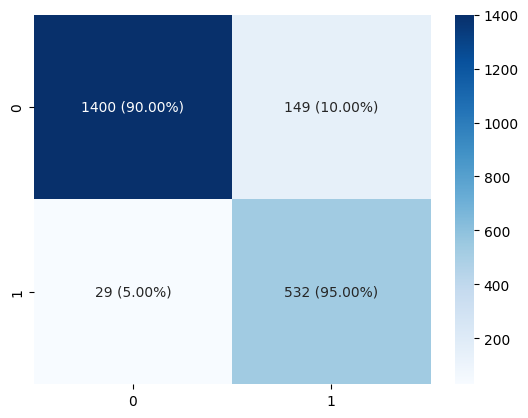

In [69]:
xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
model(xgb,X_train,Y_train,X_test,Y_test)

In [78]:
joblib.dump(xgb, 'xgb_churn_model.pkl')
print("XGBoost model saved as xgb_churn_model.pkl")

XGBoost model saved as xgb_churn_model.pkl


LOGISTIC REGRESSION

Best Logistic Regression Params: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
ROC AUC:  90.96%
Model accuracy:  89.91%
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1549
           1       0.75      0.93      0.83       561

    accuracy                           0.90      2110
   macro avg       0.86      0.91      0.88      2110
weighted avg       0.91      0.90      0.90      2110



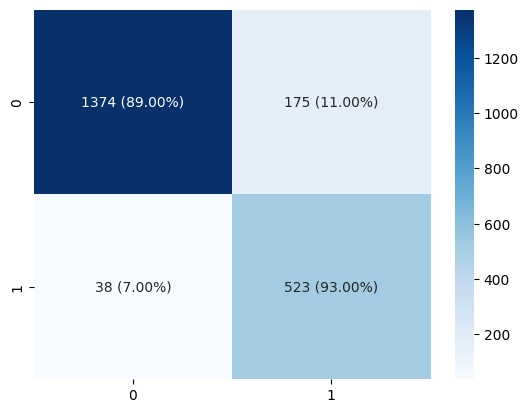

In [70]:

param_grid_lr = {
    'C': [0.001,0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500]
}

grid_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, Y_train)

best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Params:", grid_lr.best_params_)

model(best_lr, X_train, Y_train, X_test, Y_test)

RANDOM FOREST

Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
ROC AUC:  91.20%
Model accuracy:  92.42%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1549
           1       0.84      0.89      0.86       561

    accuracy                           0.92      2110
   macro avg       0.90      0.91      0.90      2110
weighted avg       0.93      0.92      0.92      2110



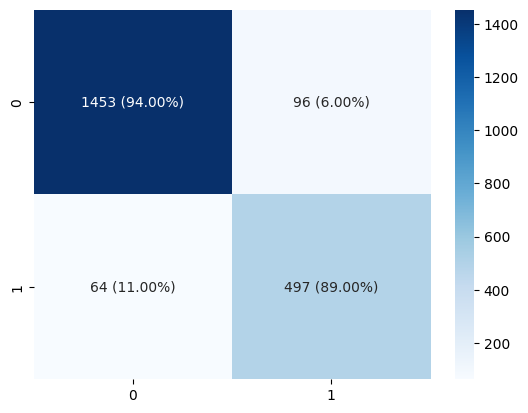

In [71]:

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'random_state': [42, 16, 21]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, Y_train)

best_rf = grid_rf.best_estimator_
print("Best Random Forest Params:", grid_rf.best_params_)

model(best_rf, X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:23:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Params: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'random_state': 42, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:23:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC:  88.98%
Model accuracy:  91.42%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1549
           1       0.84      0.84      0.84       561

    accuracy                           0.91      2110
   macro avg       0.89      0.89      0.89      2110
weighted avg       0.91      0.91      0.91      2110



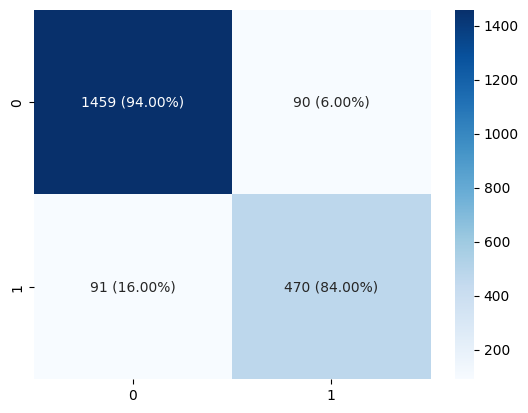

In [74]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [400, 750,1000,1200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'random_state': [42, 7]
}

grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, Y_train)

best_xgb = grid_xgb.best_estimator_
print("Best XGBoost Params:", grid_xgb.best_params_)

model(best_xgb, X_train, Y_train, X_test, Y_test)